# Tasnim News Persian Text Classification
We try to classfiy news on data from a persian news website.([dataset](https://www.kaggle.com/datasets/amirpourmand/tasnimdataset))

# Libraries

In [18]:
!pip install beautifulsoup4


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: C:\Users\HP OMEN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [19]:
from bs4 import BeautifulSoup
import re
from hazm import Normalizer
from hazm import word_tokenize
import numpy as np

import sklearn 
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd


# Load data

Reading data in persian and sampling

In [20]:
df = pd.read_csv('tasnim.csv',encoding='UTF-8')
df=df.sample(2000,random_state=42)
df.head()
df.shape

(2000, 5)

# A. Exploratory Analysis

In [21]:
df.dropna(inplace=True)

In [22]:
df.isnull().sum()

category    0
title       0
abstract    0
body        0
time        0
dtype: int64

In [23]:
# -*- coding: utf-8 -*-
classNamesp = [
        'اجتماعی','استان‌ها','اقتصادی','بین الملل','رسانه ها','فرهنگی هنری','ورزشی'
    ]
classNames =  ['Social','Regions','Economics','World','Media','Arts','Sports']

df['category']=df['category'].replace(
  {'اجتماعی':'Social','استان‌ها':'Regions','اقتصادی':'Economics','بین الملل':'World','رسانه ها':'Media','فرهنگی هنری':'Arts','ورزشی':'Sports','سیاسی':'Political'}
   )
df.groupby(['category']).count()


,title,abstract,body,time
category,,,,
Arts,253,253,253,253
Economics,260,260,260,260
Media,261,261,261,261
Political,240,240,240,240
Regions,260,260,260,260
Social,268,268,268,268
Sports,221,221,221,221
World,208,208,208,208


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Arts'),
  Text(1, 0, 'Economics'),
  Text(2, 0, 'Media'),
  Text(3, 0, 'Political'),
  Text(4, 0, 'Regions'),
  Text(5, 0, 'Social'),
  Text(6, 0, 'Sports'),
  Text(7, 0, 'World')])

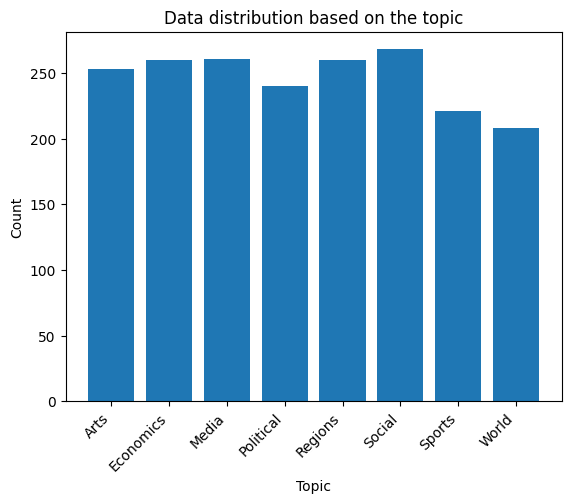

In [24]:
plt.bar(df.groupby(['category']).count().index
,df.groupby(['category']).count()['title'])
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Data distribution based on the topic')
plt.xticks(rotation=45, ha='right')

In [25]:
df['body_length'] = df['body'].apply(len)
max(df['body_length'])

30816

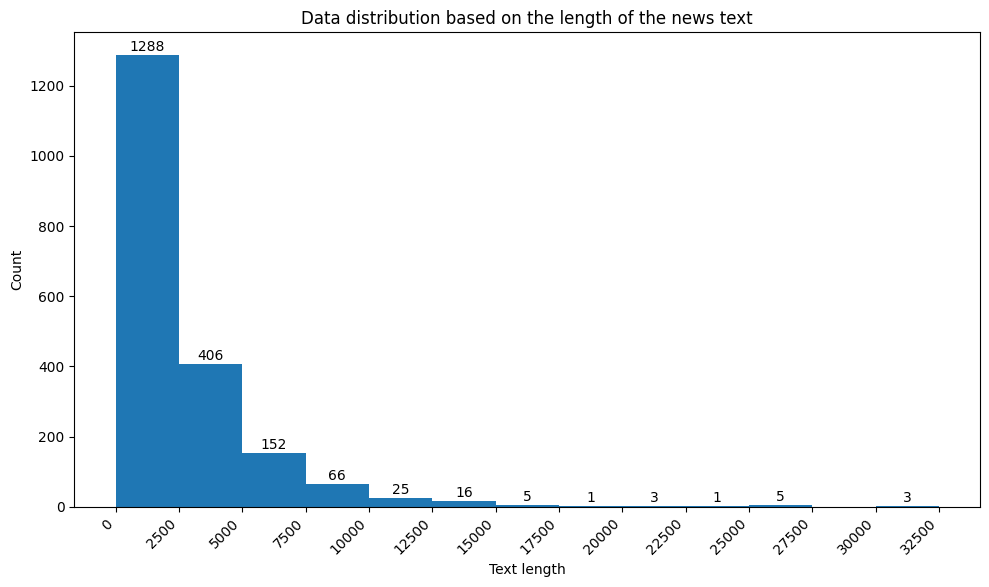

In [26]:
bins = [0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500]
plt.figure(figsize=(10, 6))
counts, _, _ = plt.hist(df['body_length'], bins=bins)

for count, x, y in zip(counts, bins[:-1], counts):
    if count > 0:
        plt.text(x+1250, y+3, str(int(count)), ha='center', va='bottom')
        
plt.xlabel('Text length')
plt.ylabel('Count')
plt.title('Data distribution based on the length of the news text')
plt.xticks(bins, rotation='vertical')
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

# B. Text Cleaning (40 points)

Deleting stopwords and unnecessary chars.
([persian stopwords](https://github.com/ziaa/Persian-stopwords-collection))

In [27]:

from hazm import word_tokenize
df.dropna(inplace=True)


In [28]:
from hazm import Normalizer
normalizer=Normalizer()

df['title'] = df['title'].apply(normalizer.normalize)
df['abstract'] = df['abstract'].apply(normalizer.normalize)
df['body'] = df['body'].apply(normalizer.normalize)
df['merged'] = df['title'] +" "+ df['abstract'] +" "+ df['body']


In [29]:

import nltk
#TODO
with open('stopwords.txt',encoding="utf-8") as f:
    persian_stopwords = f.read().splitlines()

In [32]:
nltk.download('stopwords')
from nltk.corpus import stopwords
all_stopwords=stopwords.words('english')+persian_stopwords
etc = ['پیام', 'انتهای']
all_stopwords.extend(etc)
persian_punctuation_marks = ['،', '؛', '؟', '«', '»', '“', '”', '٬', '٫', '٪', '٭', 'ـ', ':', ',', '+', '/', '-', '(', ')', '[', ']', '{', '}', '؛']
persian_punctuation_marks = ''.join(str(x) for x in persian_punctuation_marks)

#remove the punctuations and stopwords
import string
def text_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', persian_punctuation_marks))
    text = [word for word in text.split() if word.lower() not in (all_stopwords)]


    return " ".join(text)

def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text


def punctuation_removal(text):
    return re.sub(r'[\.\?\!\,\:\;\"\/\\،«»؛]', '', text)


[nltk_data] Downloading package stopwords to C:\Users\HP
[nltk_data]     OMEN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
df['text_new'] = df['merged'].apply(strip_html_tags).apply(text_process).apply(punctuation_removal)
df.head()

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_3456\3232792924.py:21: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,category,title,abstract,body,time,body_length,merged,text_new
45731,Economics,استعفای رؤسای منطقه‌ای بانک مرکزی آمریکا در پ...,رؤسای منطقه‌ای بانک مرکزی (فدرال رزرو) آمریکا...,به گزارش به نقل از راشاتودی، رؤسای منطقه‌ای با...,۰۶ مهر ۱۴۰۰ - ۱۲:۲۰,1763,استعفای رؤسای منطقه‌ای بانک مرکزی آمریکا در پ...,استعفای رؤسای منطقه‌ای بانک مرکزی آمریکا معامل...
52281,World,خطیب زاده: برخی طرف‌های خارجی در صدد دامن زدن...,سخنگوی وزارت امور خارجه کشورمان با تأکید بر ا...,به گزارش گروه بین‌الملل، سعید خطیب زاده سخنگوی...,۱۶ دی ۱۴۰۰ - ۲۲:۵۴,664,خطیب زاده: برخی طرف‌های خارجی در صدد دامن زدن...,خطیب زاده طرف‌های خارجی صدد دامن ناآرامی‌ها قز...
1791,Political,ولایتی: حاج قاسم مهم‌ترین سرداری بود که پرچم ...,مشاور مقام معظم رهبری در امور بین‌الملل گفت: ...,به گزارش گروه سیاسی، علی‌اکبر ولایتی مشاور مقا...,۱۴ دی ۱۴۰۰ - ۱۵:۳۲,2429,ولایتی: حاج قاسم مهم‌ترین سرداری بود که پرچم ...,ولایتی حاج قاسم مهم‌ترین سرداری پرچم احیای اسل...
56668,Media,زمین سوخته,عصر کنونی را باید «عصر کرونا» نامید. اگر تا ق...,، علی دارابی طی یادداشتی در روزنامه صبح نو نوش...,۱۴ ارديبهشت ۱۳۹۹ - ۰۹:۴۸,3491,زمین سوخته عصر کنونی را باید «عصر کرونا» نا...,زمین سوخته عصر عصر کرونا نامید شیوع ویروس جهان...
28373,Arts,روایت سنگری از تأثیر منفی یک کتاب اروپایی بر ...,بخشی از نویسندگان ما تحت تأثیر ادبیات جنگ در ...,به گزارش خبرنگار فرهنگی، رهبر انقلاب به مناسبت...,۰۴ خرداد ۱۴۰۰ - ۰۹:۰۶,2619,روایت سنگری از تأثیر منفی یک کتاب اروپایی بر ...,روایت سنگری تأثیر منفی کتاب اروپایی نویسندگان ...


# C. Word Cloud

In [34]:
from wordcloud_fa import WordCloudFa
from hazm import word_tokenize

p_words = ''
# Creating a corpus of political messages
c=0
for text in df[df['category'] == 'Sports']['text_new']:
    c+=1
    if c>100:
        break
    tokens = word_tokenize(text)
    for words in tokens:
        p_words = p_words + words + ' '


        
p_wordcloud = WordCloudFa(width=1000, height=600,persian_normalize=True,background_color="white", stopwords=all_stopwords).generate(p_words)


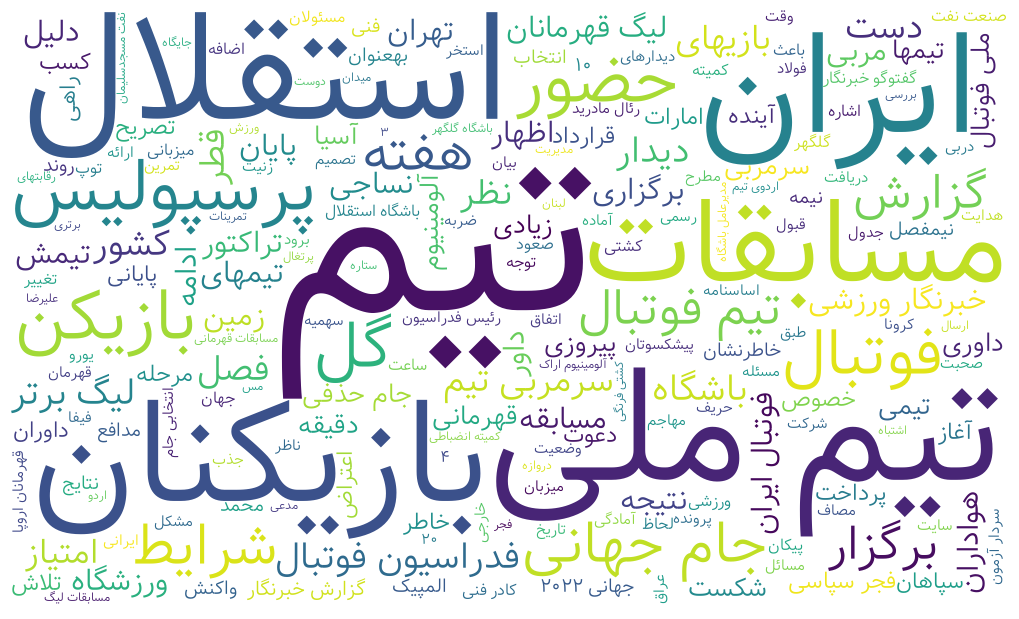

In [35]:

plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(p_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# D. Vectorization

We use two methods to vectorize our texts.TF-IDF and Count vectorization

In [36]:
#convert the text data into vectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


In [37]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf_vectorized= tfidf_vectorizer.fit_transform(df['text_new'])
X_tfidf_vectorized.shape

(1971, 31499)

In [38]:
count_vectorizer = CountVectorizer()
X_count_vectorized= count_vectorizer.fit_transform(df['text_new'])
X_count_vectorized.shape

(1971, 31499)

In [39]:
tfidf_vectorizer.get_feature_names_out()

array(['abc', 'abele', 'ac', ..., 'ﻣﺮﺗﺒﻪ', 'ﻤﯽ', 'ﻫﻴﺄﺕ'], dtype=object)

In [40]:
count_vectorizer.get_feature_names_out()

array(['abc', 'abele', 'ac', ..., 'ﻣﺮﺗﺒﻪ', 'ﻤﯽ', 'ﻫﻴﺄﺕ'], dtype=object)

# E. Train and test split

In [41]:
df.head()
y=df['category']
from sklearn.model_selection import train_test_split
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf_vectorized, y, test_size=0.33,random_state=42,shuffle=False)
X_count_train, X_count_test, y_count_train, y_count_test = train_test_split(X_count_vectorized, y, test_size=0.33,random_state=42,shuffle=False)

In [42]:
X_count_train.shape

(1320, 31499)

In [43]:
X_tfidf_train.shape

(1320, 31499)

# F. Model Training

In [54]:
# Pallets used for visualizations
color= "Spectral"
color_plt = ListedColormap(sns.color_palette(color).as_hex())
color_hist = 'teal'
two_colors = [ sns.color_palette(color)[0], sns.color_palette(color)[5]]
three_colors = [ sns.color_palette(color)[5],sns.color_palette(color)[2], sns.color_palette(color)[0]]

In [53]:
# Modeling libraries
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict,  KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from scipy.stats import zscore
from itertools import combinations
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
import warnings
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score

warnings.filterwarnings("ignore")

In [55]:
models = {
    'Linear SVC': LinearSVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=500, solver='liblinear')}

vectorizers = ['TF-IDF', 'Count']

In [52]:
score_df = pd.DataFrame(index=models.keys(), columns=vectorizers)

accuracy_df = pd.DataFrame({'Model': list(models.keys())})

k = 5

train_accuracy = {}
test_accuracy = {}

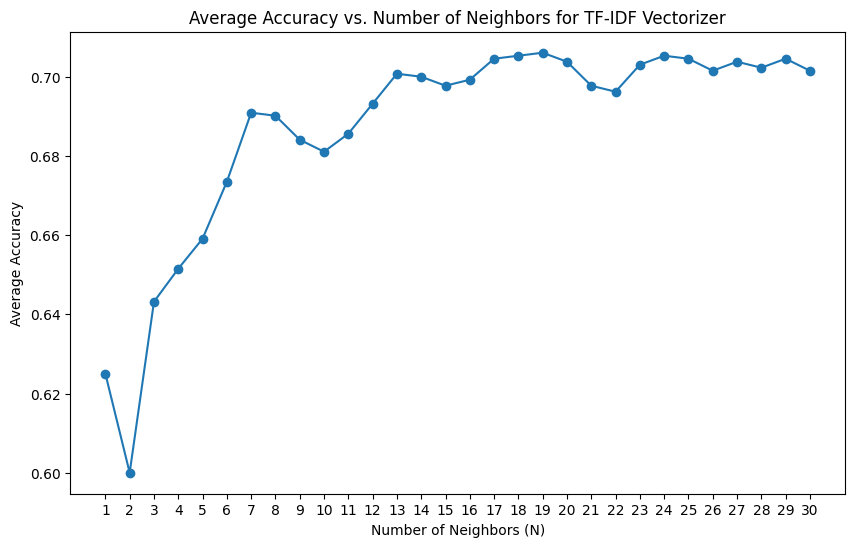

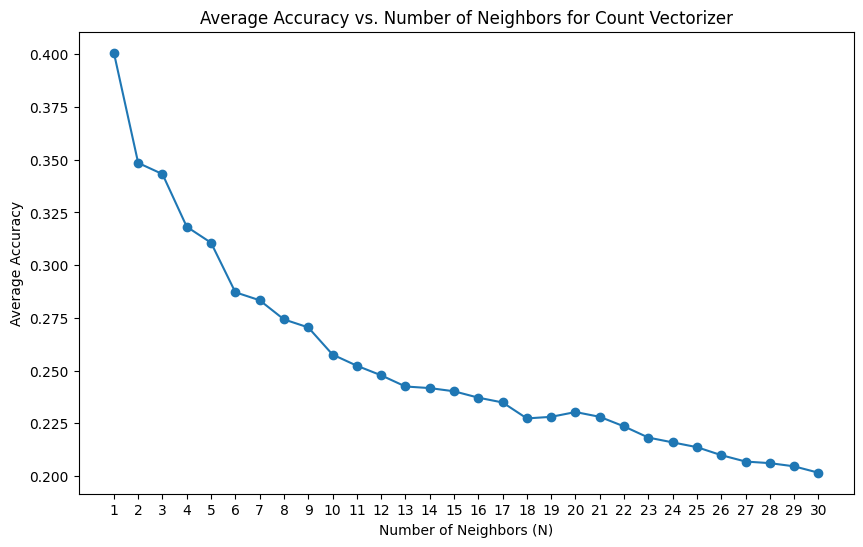

,TF-IDF,Count
Linear SVC,0.771212,0.761364
Decision Tree,0.725758,0.72197
Random Forest,0.806061,0.781818
KNN,0.685606,0.407576
Logistic Regression,0.768182,0.759091


In [56]:
for model_name, model in models.items():
    
    train_accuracy[model_name] = []
    test_accuracy[model_name] = []

    for vectorizer_name in vectorizers:
        X_train = X_tfidf_train if vectorizer_name == 'TF-IDF' else X_count_train
        X_test = X_count_test if vectorizer_name == 'TF-IDF' else X_count_test
        y_train = y_count_train if vectorizer_name == 'TF-IDF' else y_count_train
        y_test = y_tfidf_test if vectorizer_name == 'TF-IDF' else y_count_test

        if model_name == 'KNN':
            param_grid = {'n_neighbors': np.arange(1,31)}
            grid_search = GridSearchCV(model, param_grid, cv=k)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_

            n_values = param_grid['n_neighbors']
            mean_scores = grid_search.cv_results_['mean_test_score']
            
            plt.figure(figsize=(10, 6))
            plt.plot(n_values, mean_scores, marker='o')
            plt.xlabel('Number of Neighbors (N)')
            plt.ylabel('Average Accuracy')
            plt.title('Average Accuracy vs. Number of Neighbors for ' + vectorizer_name + ' Vectorizer')
            plt.xticks(np.arange(1,31))
            plt.show()

        elif model_name == 'Logistic Regression':
            param_grid = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10]}
            grid_search = GridSearchCV(model, param_grid, cv=k)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
        else:
            model.fit(X_train, y_train)

        y_test_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        train_accuracy[model_name].append(train_acc)
        test_accuracy[model_name].append(test_acc)

        kfold = KFold(n_splits=k, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_train, y_train, cv=kfold)

        avg_score = scores.mean()

        score_df.loc[model_name, vectorizer_name] = avg_score
score_df

## Analysis of the results of the first section:
In this section, the measured metric is the average score of several criteria. Now, let's analyze the table.

**For the TF-IDF Vectorizer:**
- The Random Forest model has the highest score.
- In second and third place, the Logistic Regression and Linear SVC models respectively perform well.
- The Decision Tree and KNN models have not performed well.

**For the Count Vectorizer:**
- The Logistic Regression model has the highest score.
- In second and third place, the Random Forest and Linear SVC models have performed well and are close to the best model (Random Forest).
- The Decision Tree model has a lower score compared to the three previous models.
- Finally, the KNN model has the lowest performance.

Based on the available combinations and the current information, the best combination in terms of average scores overall is the Random Forest model with the TF-IDF vectorizer. Following this combination, the Logistic Regression with the Count vectorizer, and then the Random Forest with the Count vectorizer, with very little difference in the second and third positions, have also shown good performance.

The TF-IDF vectorizer has generally performed better in all models compared to the Count vectorizer. The TF-IDF vectorization assigns higher weights to rare words present in specific documents while downplaying common words. This weighting scheme helps models focus on important and distinctive features, potentially improving their ability to classify textual data accurately.

The following reasons could explain this performance difference:

- **Importance of rare words:** TF-IDF assigns higher weights to rare words that exist in specific documents. These rare words often help models distinguish more effectively between different classes.
- **Downplaying common words:** Common words that exist in multiple documents, such as pronouns and prepositions, receive lower weights in TF-IDF. This helps models concentrate on content-specific words that are more informative for classification.
- **Noise reduction:** TF-IDF can reduce the impact of noisy and uninformative words that may not significantly contribute to classification. By reducing the weight of these words, the vectorizer helps models focus on more meaningful and relevant aspects of the text.

## Analysis of the average accuracy chart for various values of N in the KNN method

**1. KNN Model with TF-IDF Vectorizer:**
- It can be observed that as the value of N increases, the average accuracy of the KNN model with the TF-IDF vectorizer also tends to increase. The model reaches a relatively higher accuracy at around N=24 and then stabilizes with minor fluctuations.
- The TF-IDF vectorizer assigns higher weights to words that are important in a document but less common in the overall corpus. The goal of this approach is to capture the distinctive features of each document. As N increases, the KNN model considers a larger number of nearest neighbors for classification. This can lead to better generalization and improved accuracy because more relevant information from neighboring documents is taken into account. The increase in accuracy with increasing N indicates that a larger neighborhood context helps in making more accurate predictions.
- The oscillatory nature of the graph indicates that the choice of the number of neighbors significantly affects the model's performance. Changing N in the model results in different abilities to make accurate predictions on unseen data. The fluctuations and trends observed in the average scores can be attributed to the complexity of the dataset. In some cases, datasets with complex decision boundaries may require a more precise choice of N.

**2. KNN Model with Count Vectorizer:**
- Here, we observe a different behavior. As the value of N increases, the average accuracy of the model gradually decreases. The accuracy starts relatively high at N=1 but steadily decreases with increasing N.
- The Count vectorizer simply counts the frequency of each word in a document and does not consider the importance or rarity of words in the corpus. The decrease in accuracy with increasing N for the KNN model with the Count vectorizer can be attributed to dimensionality. As the number of neighbors considered increases, the feature space becomes smaller, and the relationships between the nearest neighbors may diminish. This can lead to reduced accuracy as the model becomes more susceptible to noise and less capable of good generalization.

In general, the difference in the behavior of the KNN model with the TF-IDF vectorizer and the Count vectorizer can be attributed to the distinct characteristics of the vectorization methods and their impact on capturing relevant information and managing high-dimensional feature spaces. Please note that these observations are specific to our dataset and may vary for different datasets.    

In [57]:
tfidf_train = []
tfidf_test = []
count_train = []
count_test =[]
for i in range(0, len(models.keys())):
    tfidf_train.append(list(train_accuracy.values())[i][0])
    tfidf_test.append(list(test_accuracy.values())[i][0])
    count_train.append(list(train_accuracy.values())[i][1])
    count_test.append(list(test_accuracy.values())[i][1])

accuracy_df['TF-IDF Train'] = tfidf_train
accuracy_df['TF-IDF Test'] = tfidf_test
accuracy_df['Count Train'] = count_train
accuracy_df['Count Test'] = count_test
accuracy_df

,Model,TF-IDF Train,TF-IDF Test,Count Train,Count Test
0,Linear SVC,1.000000,0.792627,1.0,0.760369
1,Decision Tree,1.000000,0.625192,1.0,0.745008
2,Random Forest,1.000000,0.814132,1.0,0.837174
3,KNN,0.740152,0.675883,1.0,0.431644
4,Logistic Regression,1.000000,0.786482,1.0,0.783410


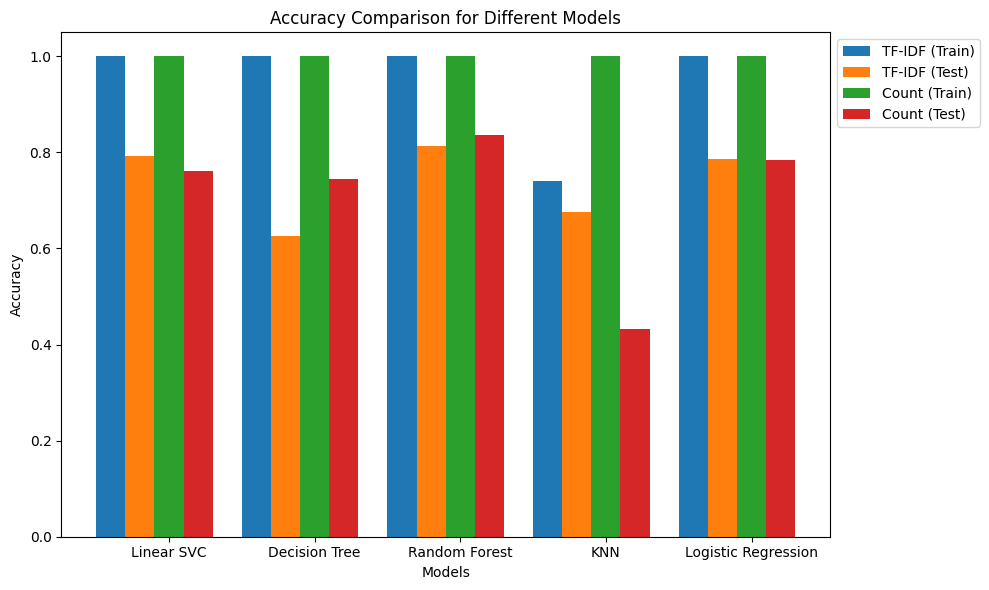

In [58]:
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(models))

train_data = accuracy_df[['TF-IDF Train', 'Count Train']].values.T
test_data = accuracy_df[['TF-IDF Test', 'Count Test']].values.T

plt.bar(index, train_data[0], bar_width, label='TF-IDF (Train)', alpha=1)
plt.bar(index + bar_width, test_data[0], bar_width, label='TF-IDF (Test)', alpha=1)
plt.bar(index + 2 * bar_width, train_data[1], bar_width, label='Count (Train)', alpha=1)
plt.bar(index + 3 * bar_width, test_data[1], bar_width, label='Count (Test)', alpha=1)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for Different Models')
plt.xticks(index + 2 * bar_width, list(models.keys()))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Analysis of the results for the second section
1. **Overfitting**: This occurs when a model becomes overly complex and captures noise or specific patterns in the training data that may not generalize well to new, unseen data. Consequently, the model may achieve a high accuracy on the training set but perform poorly on the test set, resulting in a noticeable difference in accuracy.
    - **TF-IDF Vectorizer**:
        - Training Accuracy: This model achieves a high accuracy on the training data because it learns patterns and specific features present in the training dataset. It can assign importance weights to words and closely match the training data.

        - Test Accuracy: The model's performance on the test data may be slightly lower due to overfitting. It could become highly specialized in capturing subtle nuances in the training data, making it less effective in generalizing to unseen data. It might struggle to handle variations and noise in the test data.
        
    - **Count Vectorizer**:
        - Training Accuracy: Similar to TF-IDF, this model achieves high accuracy by learning patterns and frequency-based features present in the training data. It perfectly matches the data based on word frequencies.
        
        - Test Accuracy: Test accuracy may also be slightly lower than training accuracy due to overfitting. This model might have learned specific word frequencies and combinations that are unique to the training data, making it less effective at generalizing to unseen data. It may struggle with handling semantic changes and domain differences in test data.

2. **Data Distribution Differences**: Training and test datasets may inherently differ in their distributions. If test data significantly differs from training data in terms of features, patterns, or fundamental characteristics, the model's performance can be adversely affected, leading to a gap between training and test accuracy.

3. **Limited Generalization**: Some models may struggle to generalize well to unseen data due to their complexity or inherent limitations. This can result in a gap between accuracy achieved on training data (where the model is more familiar) and accuracy on test data (representing new and unseen samples).

4. **Feature Selection**: Differences in accuracy can also result from feature engineering and selection processes. If the selected features do not adequately capture underlying patterns or if irrelevant features are included, the model's performance can be affected, leading to accuracy fluctuations.

5. **Hyperparameter Tuning**: Differences in accuracy can be attributed to changes in hyperparameter settings. Models may be tuned to perform well on the training data, resulting in high training accuracy. However, the same hyperparameters may not generalize optimally to the test set.

To mitigate these accuracy differences, techniques such as regularization, cross-validation, and increasing the size of the training dataset can be employed. Regularization methods like L1 or L2 in Logistic Regression can prevent overfitting by adding penalties to complex model parameters. Cross-validation provides a better estimate of model performance on unseen data. Increasing the training data can expose the model to a more diverse set of samples, aiding in better generalization.

**Criterion for Assessing Performance**

Consider the following criterion for assessing performance:

1. **Excellent Performance**: High accuracy in both test and training data.

2. **Good Performance**: High accuracy in either test or training data.

3. **Average Performance**: Moderate accuracy in both test and training data.

4. **Failure**: Low accuracy in both test and training data.

Now, with the defined criterion, we rank different combinations and determine the type of performance and the reasons for it.
1. Random Forest Model and TF-IDF Vectorizer: **Excellent**  
This combination has achieved high accuracy in both test and training data. The Random Forest model is an ensemble learning algorithm that can overcome the limitations of individual decision trees and combines multiple decision trees to make predictions for the combination. TF-IDF vectorization effectively represents the importance of words in the text, which helps Random Forest capture relevant features and achieve excellent performance.

2. Random Forest Model and Count Vectorizer: **Excellent**  
This model leverages its collective nature to handle complex patterns effectively. Additionally, the Count vectorizer, while not capturing word importance, still provides frequency information that can be valuable for the decision-making process of Random Forest.

3. Linear SVC Model and TF-IDF Vectorizer: **Excellent**  
The Linear SVC model is a linear classifier that aims to find the best hyperplane for data point separation and works well with high-dimensional data, making it suitable for text classification tasks. TF-IDF vectorization highlights word importance in documents and enables Linear SVC to utilize informative features effectively.

4. Logistic Regression Model and Count Vectorizer: **Good**  
The Logistic Regression model shows good performance with the Count vectorizer. This model is a popular classification algorithm that models the relationship between features and target classes. Although the Count vectorizer does not capture word importance, it can still be effective in using frequency information for classification.

5. Logistic Regression Model and TF-IDF Vectorizer: **Good**  
The Logistic Regression model, a linear classifier, works well with high-dimensional data. TF-IDF vectorization allows it to make effective use of important words for classification, resulting in good overall performance.

6. Decision Tree Model and TF-IDF Vectorizer: **Good**  
Despite its susceptibility to overfitting, especially with high-dimensional data, this combination has shown relatively good performance. The Decision Tree model is a non-parametric algorithm that creates a tree-like model for prediction. TF-IDF vectorization effectively highlights important features, aiding the Decision Tree in capturing relevant patterns and achieving good performance.

7. Decision Tree Model and Count Vectorizer: **Good**  
Similar to the previous combination, it has achieved a good accuracy score. The reason for the lower accuracy is that Decision Tree models may struggle with overfitting when using the Count vectorizer. The frequency-based representation may not capture word importance well enough, leading to slightly lower performance.

8. K-Nearest Neighbors (KNN) Model and TF-IDF Vectorizer: **Average**  
The KNN model is a distance-based algorithm relying on similarity between data points. TF-IDF vectorization may not be well-suited for KNN, as it primarily focuses on word importance rather than patterns of occurrence. KNN may attempt to find meaningful neighbors and achieve moderate performance. TF-IDF vectorization helps highlight important features, but KNN may not effectively capture complex patterns, resulting in average performance.

9. Linear SVC Model and Count Vectorizer: **Average**  
The primary goal of the Linear SVC algorithm is to find the best hyperplane for data point separation. However, the Count vectorizer may not provide efficient information like frequency and word importance to Linear SVC, which leads to average performance.

10. K-Nearest Neighbors (KNN) Model and Count Vectorizer: **Failure**  
This combination falls into the failure category due to its low accuracy in both test and training data. The KNN model may not perform well with the Count vectorizer, as the Count vectorization may not adequately capture relative word importance, leading to poor neighbor selection and lower performance.

**Note about Training Data Accuracy**  

The reason for the high accuracy of most training data (exactly 1) is that the training accuracy is calculated immediately after fitting the models to the training data. Since the models have seen and learned from the training data beforehand, they can accurately predict the training samples, resulting in high training accuracy. This behavior is expected and not necessarily indicative of overfitting.  However, it is important to emphasize that when evaluating model performance, the primary focus should be on test accuracy rather than training accuracy. Test accuracy measures the model's generalization to unseen data. Therefore, the emphasis should be on analyzing and interpreting test accuracy rather than training accuracy. If test accuracy consistently remains high across different models and vectorizers, it indicates that the models perform well on unseen data. On the other hand, if there is a significant drop in test accuracy compared to training accuracy, it may indicate a potential overfitting issue. Therefore, when considering the ranking, we only take into account test accuracy with the new criterion definition:

1. Random Forest Model and TF-IDF Vectorizer: **Excellent**

2. Random Forest Model and Count Vectorizer: **Excellent**

3. Linear SVC Model and TF-IDF Vectorizer: **Excellent**

4. Logistic Regression Model and TF-IDF Vectorizer: **Good**

5. Logistic Regression Model and Count Vectorizer: **Good**

6. Linear SVC Model and Count Vectorizer: **Good**

7. Decision Tree Model and Count Vectorizer: **Good**

8. K-Nearest Neighbors (KNN) Model and TF-IDF Vectorizer: **Good**

9. Decision Tree Model and TF-IDF Vectorizer: **Failure**

10. K-Nearest Neighbors (KNN) Model and Count Vectorizer: **Failure**

It is observed that due to the change in the criterion definition, the ranking has slightly changed from the previous evaluation. However, Random Forest models with either TF-IDF or Count vectorization are still the top-performing models in terms of accuracy.

</div>

In [47]:
# old code
# def model_metrics(model, kfold, X_train, X_test, y_train, y_test):
    
#     model.fit(X_train, y_train)

#     #metrics
#     results = cross_val_score(model, X_train, y_train, cv = kfold)
#     print("CV scores: ", results); print("CV Standard Deviation: ", results.std()); print();
#     print('CV Mean score: ', results.mean()); 
#     print('Test score:    ', model.score(X_test, y_test))
    
#     pred = model.predict(X_test)
#     print("\n")
#     print()
#     print('Confusion Matrix: ')
#     print(confusion_matrix(y_test, pred))
#     print('Classification Report:  ')
#     print(classification_report(y_test, pred))
#     train_score =  model.score(X_train, y_train)
#     test_score = model.score(X_test, y_test)
#     test_pred = model.predict(X_test)
#     return test_pred, test_score, results.mean()


In [ ]:
# Old code
# def basic_classifiers (X_train, X_test, y_train, y_test, kfold):
#     BOLD = '\033[1m'
#     END = '\033[0m'
        
#     print(); print(BOLD + 'SVC Classifier Model:' + END)
#     svc = SVC(random_state=42,kernel='linear', degree=3, gamma='auto')
    
#     svc_pred, svc_test, svc_train = model_metrics(svc, kfold, X_train, X_test, y_train, y_test)


#     ######################################################################################################  K Neighbors Classifier model
    
#     params = {
#     "n_neighbors" : [5,15,25,30,35,40, 100],
#     "weights" : ["uniform" , "distance"]
#     }
#     print(); print(BOLD + 'K Neighbors Classifier Model:' + END)
#     knn= GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, cv=4)
#     knn_pred, knn_test, knn_train = model_metrics(knn, kfold, X_train, X_test, y_train, y_test)
    
#     ###################################################################################################### Logistic Regression
#     params = {
#     "penalty": ["l1", "l2"],
#     "C": np.logspace(-2,4,10)
#     }
#     print(); print(BOLD + 'Logistic Regression Model:' + END)
#     logistic_regression = GridSearchCV(LogisticRegression(random_state=42,multi_class="multinomial"), params, n_jobs=-1, cv=4)
#     lg_pred, lg_test, lg_train = model_metrics(logistic_regression, kfold, X_train, X_test, y_train, y_test)
    
#     ###################################################################################################### Decision Tree
    
#     print(); print(BOLD + 'Decision Tree Classifier Model:' + END)
#     decision_tree = DecisionTreeClassifier(random_state=42)
#     dt_pred, dt_test, dt_train = model_metrics(decision_tree, kfold, X_train, X_test, y_train, y_test)
    
#     ###################################################################################################### Random Forest Classifier
    
#     print(); print(BOLD + 'Random Forest Classifier Model:' + END)
#     random_forest = RandomForestClassifier(random_state=42)
#     rf_pred, rf_test, rf_train = model_metrics(random_forest, kfold, X_train, X_test, y_train, y_test)
    

#     ###################################################################################################### SVC Classifier

#     fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(15,6))

    
#     #bar chart of accuracy scores
#     inds = range(1,6)
#     labels = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest", 'SVC' ]
#     scores_all = [knn_train, lg_train, dt_train, rf_train, svc_train]
#     scores_predictive = [knn_test, lg_test, dt_test, rf_test,  svc_test]
    
#     ax1.bar(inds, scores_all, color=sns.color_palette(color)[5], alpha=0.3, hatch="x", edgecolor="none",label="CrossValidation Set")
#     ax1.bar(inds, scores_predictive, color=sns.color_palette(color)[0], label="Testing set")
#     ax1.set_ylim(0.4, 1)
#     ax1.set_ylabel("Accuracy score")
#     ax1.axhline(0.5793, color="black", linestyle="--")
#     ax1.set_title("Accuracy scores for basic models", fontsize=17)
#     ax1.set_xticks(range(1,6))
#     ax1.set_xticklabels(labels, size=12, rotation=40, ha="right")
#     ax1.legend()
#     plt.show()
#     return logistic_regression,svc,random_forest,decision_tree,knn

In [48]:
#old code
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score
# def plot_confusion_matrix(y_test,y_scores, classNames):
#     classes = len(classNames)
#     cm = confusion_matrix(y_test, y_scores)
#     print("**** Confusion Matrix ****")
#     print(cm)
#     print("**** Classification Report ****")
#     print(classification_report(y_test, y_scores, target_names=classNames))
#     con = np.zeros((classes,classes))
#     for x in range(classes):
#         for y in range(classes):
#             con[x,y] = cm[x,y]/np.sum(cm[x,:])
            
#     df = sns.heatmap(con, annot=True,fmt='.2', cmap='Blues',xticklabels= classNames , yticklabels= classNames)

# G. Predictor function

In [59]:
def find(model,vectorizer,texts):
    
    result=pd.DataFrame(texts,columns=['text'])
    result['text'].apply(strip_html_tags).apply(normalizer.normalize).apply(text_process).apply(punctuation_removal)
    y_pred=model.predict(vectorizer.transform( result))


    return y_pred

In [60]:
test_text = ["""
مذاکرات مثبت استقلال و ساپینتو برای تمدید قراردادباشگاه استقلال با انتشار اطلاعیه‌ای اعلام کرد که با مربی دیگری مذاکره نکرده و صحبت‌های انجام شده با ساپینتو مثبت بوده است.مذاکرات مثبت استقلال و ساپینتو برای تمدید قرارداد
به گزارش "ورزش سه"، بحث حضور ریکاردو ساپینتو روی نیمکت استقلال در فصل بعد مسئله‌ای است که حتی منجر به واکنش این مربی پس از پایان دیدار با مس رفسنجان شد. جایی که او مدعی شد حتی برنامه‌ریزی از الآن برای فصل بعد نیز دیر شده است و قرارداد شخصی که عملکرد خوبی روی نیمکت تیم داشته، باید زودتر از این‌ها تمدید می‌شد.

در شرایطی که هنوز وضعیت مدیریت استقلال برای فصل بعد نامشخص است و حتی ساپینتو نیز به این نکته اشاره کرد که ماندن حجت کریمی در این باشگاه نامشخص است، اما آبی‌ها امیدوار هستند تا در مذاکرات با سرمربی پرتغالی، موفق به جلب رضایت او شوند.

ساپینتو با استقلال قراردادی 2 ساله دارد اما برای سال دوم باید طرفین به توافق برسند و به همین دلیل باشگاه استقلال از هفته‌های قبل صحبت‌های ابتدایی با این سرمربی و مدیر برنامه‌هایش آغاز کرده است ولی تاکنون نتیجه‌ای از روند صحبت‌های طرفین رسانه‌ای نشده است.


آخرین واکنش کریمی به بحث تمدید قرارداد ساپینتو این گفته‌ها بود: ما از هر نظر آماده و مهیای تمدید قرارداد با سرمربی تیم هستیم. آژانس نقل و انتقالاتی ساپینتو هم در این زمینه همکاری‌های لازم را با ما انجام داده است اما فعلاً خود ساپینتو می‌خواهد در این باره بیشتر فکر کند که ما هم به تصمیمات او احترام می‌گذاریم و همچنان منتظر می‌مانیم.

1868404
با این حال، شایعاتی درباره نیمکت استقلال برای فصل بعد شکل گرفته بود که این مسئله باعث شد تا آبی‌ها به صورت رسمی اطلاعیه‌ای صادر کنند. در این بیانیه آمده است: برخلاف برخی شایعات مطرح شده، این باشگاه هیچ گونه مذاکره مستقیم و یا غیر مستقیمی با هیچ مربی دیگری نداشته است.

بخش بعدی این اطلاعیه که حاوی نکات مهمی است، از مثبت بودن روند صحبت‌های طرفین خبر می‌دهد و آمده است: ضمن احترام کامل به مربیان کشورمان، همان طور که حجت کریمی سرپرست مدیرعاملی باشگاه استقلال پیش از این اعلام کرده بود، این باشگاه گزینه‌ای غیر از ریکاردو ساپینتو برای سرمربیگری این تیم در فصل آینده ندارد و مذاکرات مثبت دو طرف در همین خصوص ادامه دارد.

به هر شکل استقلال در مقطع حساسی از فصل قرار دارد و تمام تمرکز آبی‌ها روی دیدار جام حذفی است و باید دید که استقلال چه نتیجه‌ای برابر نساجی کسب می‌کند. ساپینتو امید زیادی به کسب قهرمانی در این رقابت‌ها دارد.
"""]


In [61]:
find(models['Random Forest'],tfidf_vectorizer,test_text)

array(['Media'], dtype=object)

Part of this notebook was constructed based on answers of [Mahan Pourhosseini](https://github.com/MahanPourhossein) who was a student in the [ML course](https://github.com/ammahmoudi/IntroductionToMachineLearning) in which I was the TA.